# Homework 1: Text Mining
## Part 2: Text analysis

Group Members: Matias Borrel, Pol Garcia, Marvin Ernst

#### Importing relevant Libraries:

In [81]:
import os
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /Users/Admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/Admin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#### Define file paths:

In [82]:
files = {
    "Barcelona": {
        "Pre": "./Data_Barna/Pre-Treatment_Barna-Hotels-dataframe-04-11.csv",
        "Post": "./Data_Barna/Post-Treatment-Barna-Hotels-dataframe-12-15.csv",
    },
    "Madrid": {
        "Pre": "./Data_Madrid/Pre-treatment-Madrid-Hotels-dataframe-04-11.csv",
        "Post": "./Data_Madrid/Post-Treatment-Madrid-Hotels-dataframe-12-15.csv",
    },
}

#### Load Data:

In [83]:
dataframes = {city: {key: pd.read_csv(path) for key, path in city_files.items()} for city, city_files in files.items()}

#### Inspect the data frames:

Print column names for each dataframe:

In [84]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        print(f"{city} - {period}:")
        print(df.columns)
        print("\n")

Barcelona - Pre:
Index(['Name', 'Price', 'Score', 'Description'], dtype='object')


Barcelona - Post:
Index(['Name', 'Price', 'Score', 'Description'], dtype='object')


Madrid - Pre:
Index(['Name', 'Price', 'Score', 'Description'], dtype='object')


Madrid - Post:
Index(['Name', 'Price', 'Score', 'Description'], dtype='object')




#### Preparing the Dataframes

We want that pre and post treatment we have the same units (here "hotels") in each of the groups (here "city"). 

Filter Out Rows with Empty Names, or missing values for any of the columns:

In [85]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        # Drop rows with missing values in any column
        dataframes[city][period] = df.dropna(how='any')

Retain Only Names Present in Both Pre and Post:

In [86]:
for city, periods in dataframes.items():
    # Get the intersection of names in Pre and Post datasets
    common_names = set(periods['Pre']['Name']).intersection(set(periods['Post']['Name']))
    
    # Filter rows in both Pre and Post to only include these common names
    dataframes[city]['Pre'] = periods['Pre'][periods['Pre']['Name'].isin(common_names)]
    dataframes[city]['Post'] = periods['Post'][periods['Post']['Name'].isin(common_names)]

Verify Results:

In [87]:
for city, periods in dataframes.items():
    print(f"{city} - Pre dataset shape: {periods['Pre'].shape}")
    print(f"{city} - Post dataset shape: {periods['Post'].shape}")
    print(f"{city} - Common Names: {len(set(periods['Pre']['Name']).intersection(set(periods['Post']['Name'])))}")

Barcelona - Pre dataset shape: (439, 4)
Barcelona - Post dataset shape: (439, 4)
Barcelona - Common Names: 439
Madrid - Pre dataset shape: (611, 4)
Madrid - Post dataset shape: (611, 4)
Madrid - Common Names: 610


Check for duplicates:

In [88]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        # Check for duplicates in the 'Name' column
        duplicate_count = df['Name'].duplicated().sum()  # Count duplicates
        total_names = df['Name'].shape[0]  # Total number of rows
        print(f"{city} - {period}:")
        print(f"Total Names: {total_names}, Duplicates: {duplicate_count}")
        
        if duplicate_count > 0:
            # Display duplicate rows
            duplicates = df[df['Name'].duplicated(keep=False)]
            print("Duplicate Names:")
            print(duplicates[['Name']])
        print("\n")

Barcelona - Pre:
Total Names: 439, Duplicates: 0


Barcelona - Post:
Total Names: 439, Duplicates: 0


Madrid - Pre:
Total Names: 611, Duplicates: 1
Duplicate Names:
               Name
168  Exyca Malasaña
175  Exyca Malasaña


Madrid - Post:
Total Names: 611, Duplicates: 1
Duplicate Names:
           Name
450  FUENCARRAL
963  FUENCARRAL




#### Convert the Price to numeric:

In [89]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        # Remove all non-numeric characters (e.g., € and spaces) and dots (thousands separators)
        df['Price'] = (
            df['Price']
            .astype(str)  # Ensure the column is treated as strings
            .str.replace(r'[^\d]', '', regex=True)  # Remove non-numeric characters
            .astype(int)  # Convert cleaned strings to integers
        )

Verify the changes:

In [90]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        print(f"--- {city} - {period} ---")
        print(df[['Name', 'Price']].head())  # Show the 'Name' and cleaned 'Price' columns
        print("\n")

--- Barcelona - Pre ---
                     Name  Price
0        Hotel Casa Bonay   2708
2         Tembo Barcelona   2743
4  Golden Hotel Barcelona   1535
5  Unite Hostel Barcelona   1675
6              Vincci Bit   1673


--- Barcelona - Post ---
                         Name  Price
8           Catalonia Albeniz    433
10  Occidental Barcelona 1929    461
11        Chic & Basic Velvet    400
13           Catalonia Atenas    438
14             Catalonia Roma    433


--- Madrid - Pre ---
                                           Name  Price
1  El Autor Hotel, Madrid, Autograph Collection   2811
5                           Hostal Flat55Madrid    738
6                              Urban Inn Madrid    316
7                                Hostal Aguilar   1060
9          Hostal A Nuestra Senora de La Paloma    917


--- Madrid - Post ---
                             Name  Price
1  Only YOU Boutique Hotel Madrid    927
2              Hostal Silserranos    319
3          JC Rooms Santo Dom

Summarize and Compare:

In [91]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        avg_price = round(df['Price'].mean(), 2)  # Round average price to 2 decimal places
        avg_score = round(df['Score'].mean(), 2)  # Round average score to 2 decimal places
        print(f"{city} - {period}: Avg Price = {avg_price}, Avg Score = {avg_score}")

Barcelona - Pre: Avg Price = 2263.59, Avg Score = 8.11
Barcelona - Post: Avg Price = 657.46, Avg Score = 8.11
Madrid - Pre: Avg Price = 1338.27, Avg Score = 7.79
Madrid - Post: Avg Price = 614.88, Avg Score = 7.8


## (a) Preprocess the Text 

#### Normalize and Remove Special Characters:

In [92]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        df['Description'] = df['Description'].str.replace(r'[√©√±]', '', regex=True)

#### Tokenize, Remove Stop Words, and Stem:

In [93]:
stop_words = set(stopwords.words('spanish'))  # Spanish stop words
stemmer = PorterStemmer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [stemmer.stem(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_tokens)

for city, periods in dataframes.items():
    for period, df in periods.items():
        df['Cleaned_Description'] = df['Description'].apply(preprocess_text)

## (b) Create Word Clouds:

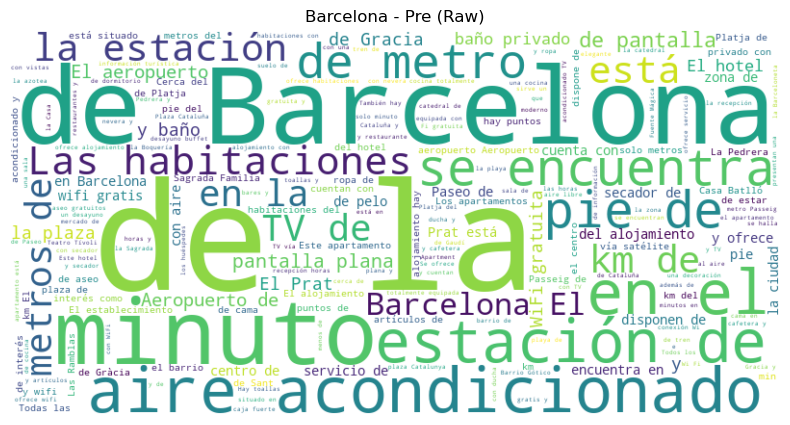

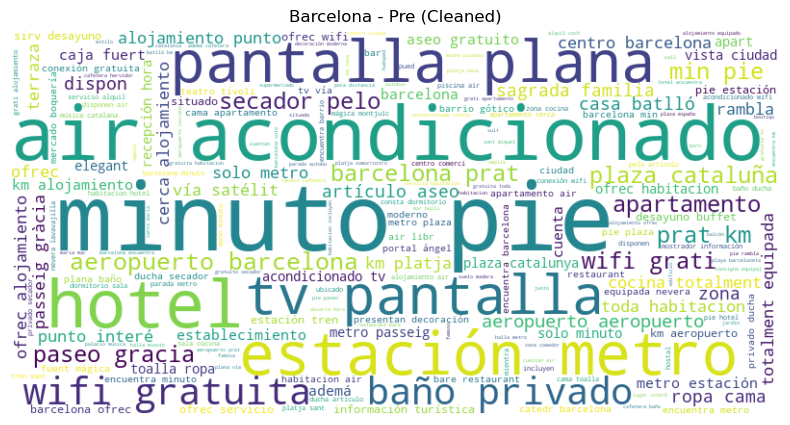

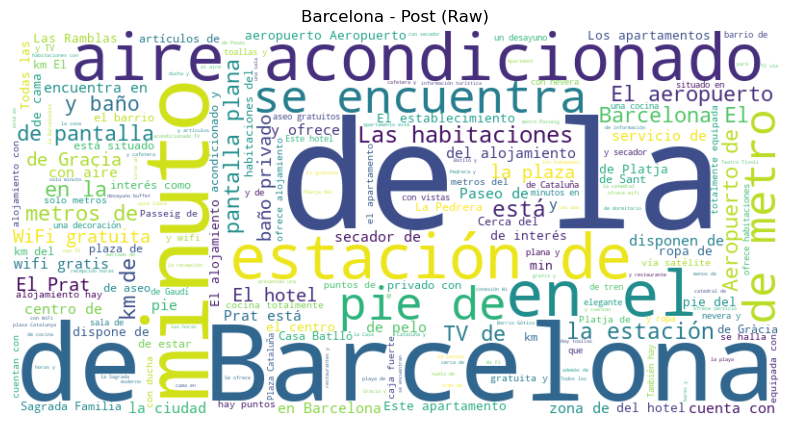

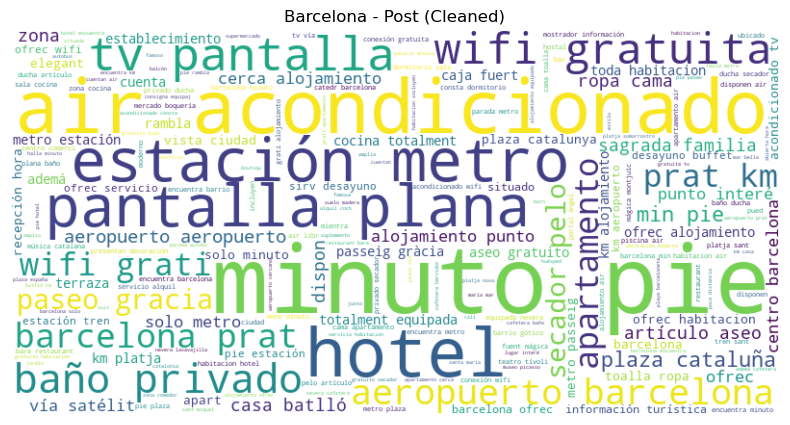

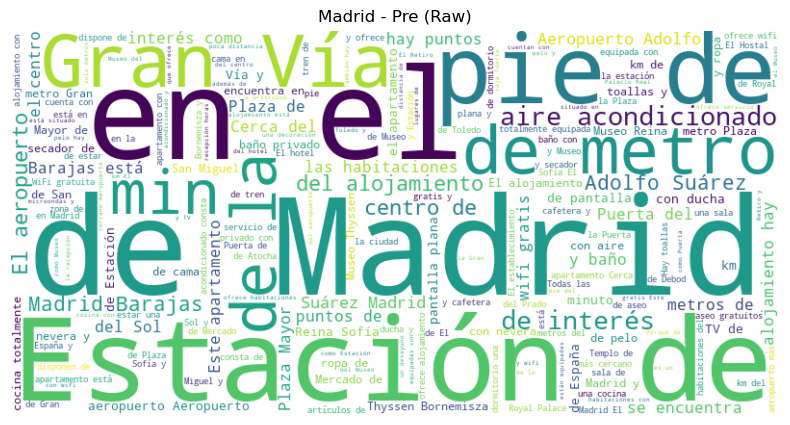

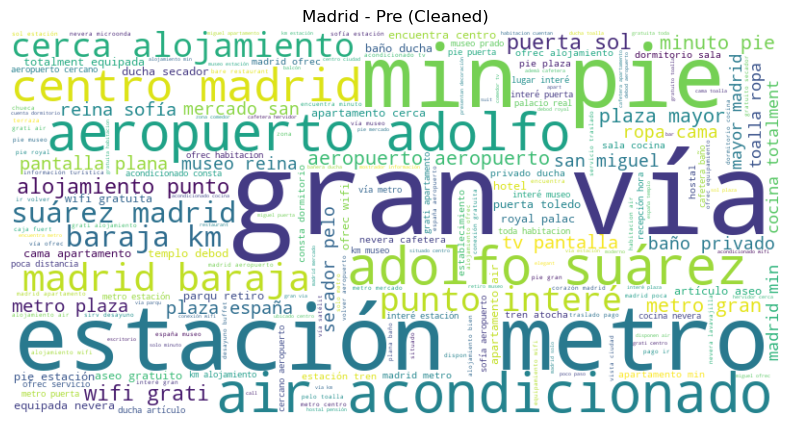

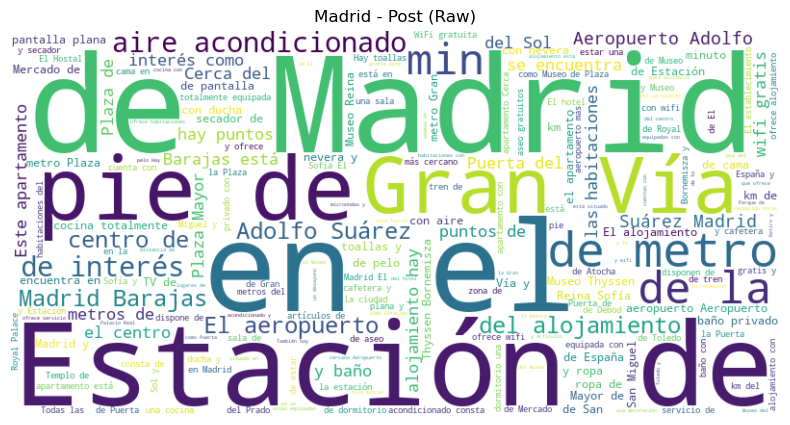

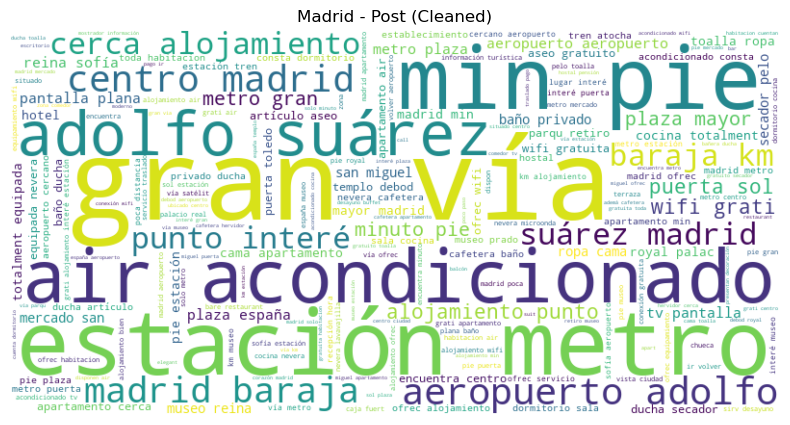

In [94]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

for city, periods in dataframes.items():
    for period, df in periods.items():
        # Raw text word cloud
        generate_wordcloud(df['Description'], f"{city} - {period} (Raw)")

        # Preprocessed text word cloud
        generate_wordcloud(df['Cleaned_Description'], f"{city} - {period} (Cleaned)")

####  Save Cleaned Data:

In [95]:
for city, periods in dataframes.items():
    for period, df in periods.items():
        df.to_csv(f"{city}_{period}_cleaned.csv", index=False)